In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
plt.rcdefaults()
%matplotlib inline
import random
import seaborn as sns


from time import time
from sklearn import datasets
from collections import Counter
from statistics import mode
from IPython.display import display, HTML
from itertools import chain
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import ParameterGrid, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

### Loading the Dataset

We are using a smaller dataset due to computational constraints, but ca be extended to larger datasets like MNIST

In [2]:
digits = datasets.load_digits()

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    digits.data, digits.target, test_size=0.2, random_state=42
)

# Display the shape of the resulting sets
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (1437, 64)
y_train shape: (1437,)
x_test shape: (360, 64)
y_test shape: (360,)


##### Viewing a few Images

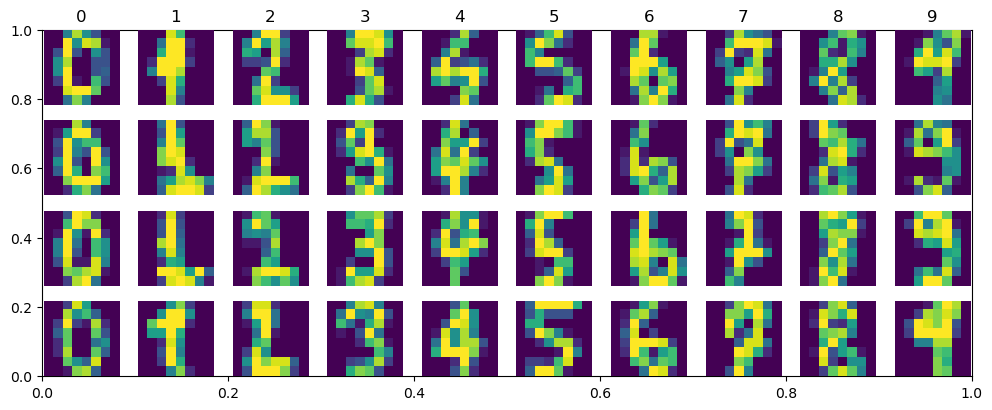

In [3]:
classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
num_classes = len(classes)
samples = 4

plt.subplots(figsize=(12, 4.5))
for y, cls in enumerate(classes):
    idxs = np.nonzero([i == y for i in y_train])
    idxs = np.random.choice(idxs[0], samples, replace=False)
    for i , idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples, num_classes, plt_idx)
        plt.imshow(x_train[idx].reshape((8, 8)))
        plt.axis("off")
        if i == 0:
            plt.title(cls)
        

plt.show()

In [4]:
# we want our images to be flattened as it will help in our computation
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

### LinearSVC Model

In [5]:
svm = LinearSVC(dual=False)
svm.fit(x_train, y_train)

LinearSVC(dual=False)

In [6]:
svm.coef_.shape

(10, 64)

The input data in this case was an 8*8 image and total of 10 possible output classes were possible. so now SVM classifier learns a set of coefficients for each class available in the training set. we flattened our image and fed the each pixel as a feature. 

Therefore the data will have 64 features and 10 possible classes, the SVM classifier will learn a total of 64*10 coefficients. which is denoted by the shape of the coef_ attribute

In [7]:
svm.intercept_

array([-5.04524819e-03, -4.13022595e+00, -8.14414113e-03, -4.90777667e-02,
       -1.24460172e-03, -3.76516391e-02, -1.45771025e-02, -1.09360150e-02,
       -2.56970630e+00, -2.11034152e+00])

Intercept or the bias term is one for every class, so the svm classifier learns 10 intercepts

In [8]:
pred = svm.predict(x_test)
accuracy_score(y_test, pred)

0.95

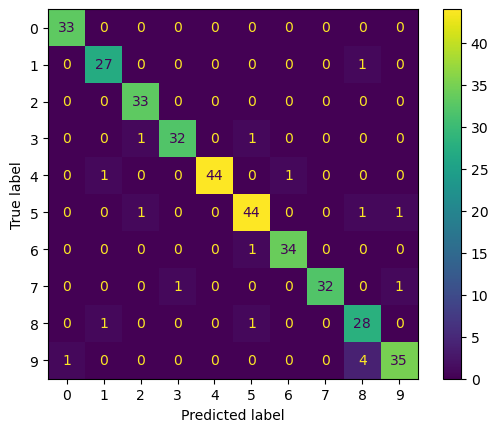

In [9]:
confusion_matrix1 = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay.from_predictions(y_test, pred)
plt.show()

##### Looking at some of the wrongly classified Images

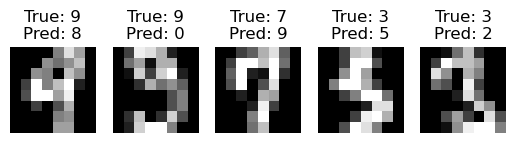

In [10]:
incorrect_indices = y_test != pred
num_samples = 5

for i in range(num_samples):
    lbl = y_test[incorrect_indices][i]
    lbl2 = pred[incorrect_indices][i]
    op = x_test[incorrect_indices][i].reshape((8,8))
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(op, cmap='gray')
    plt.title(f'True: {lbl}\nPred: {lbl2}')
    plt.axis('off')

plt.show()

##### Experimenting with different parameter values

In [11]:
acc = []
acc_tr = []
coefficient = []
for c in [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]:
    svm = LinearSVC(dual=False, C=c)
    svm.fit(x_train, y_train)
    coef = svm.coef_
    
    p_tr = svm.predict(x_train)
    a_tr = accuracy_score(y_train, p_tr)
    
    pred = svm.predict(x_test)
    a = accuracy_score(y_test, pred)
    
    coefficient.append(coef)
    acc_tr.append(a_tr)
    acc.append(a)

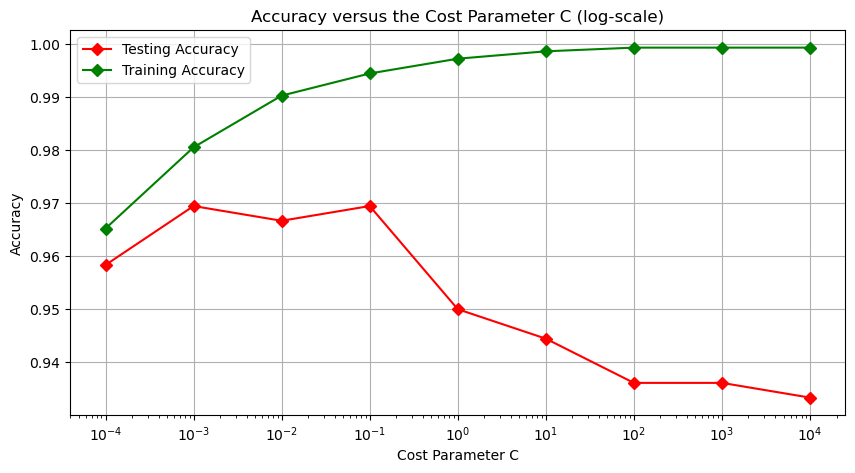

In [12]:
c = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

plt.subplots(figsize=(10, 5))
plt.semilogx(c, acc,'-gD' ,color='red' , label="Testing Accuracy")
plt.semilogx(c, acc_tr,'-gD' , label="Training Accuracy")
plt.grid(True)
plt.xlabel("Cost Parameter C")
plt.ylabel("Accuracy")
plt.legend()
plt.title('Accuracy versus the Cost Parameter C (log-scale)')
plt.show()

##### Inference from Graph

"C" indicates the inverse of the regularization strength

Generally we want the classifier to maximize the margin (or minimize the inverse of the margin) of separation, but in cases where the linear separability of the data isn't as obvious or in some cases, not available, then just maximising the margin may not work out or may result in overfitting to the training data, so we allow some slack in the prediction error, in a way to allow the classifier to make a few misclassifications in order to generalize a bit better, but allowing the errors (slack) without any constraints means that the classifier will run wild and classify all the images wrongly. so as a way to ensure there are some constraints to the allowed misclassifications, we add the errors made (scaled by some constant "C") due to misclassification to the objective function (minimizing the inverse of margin). 

1. Effectively if the "C" value is too large then its basically the same as going back to the original classifier with no slack or no misclassifications allowed, since a large value is added to the minimizing function and any misclassification made will add hugely to the function we try to minimize. 
2. If the "C" is too small, then the model allows misclassifications in order to leave out the noise and generalize better.

* And in our data we see that we get the best test results when "C" is either 0.001 or 0.1 (because we are able to generalize better)
* With higher "C" although the training set gives better accuracies, the classifier is overfitting which is why we see a drop in test scores

In a way we can also say that as we increase the value of "C", on an average-
1. The bias of the classifier (which is a measure of how well the classifier captures the underlying complexity of the data) keeps decreasing.
2. The variance of the classifier (which captures how well the classifier is able to generalize) increases

In [13]:
# choosing the parameter that resulted in the highest test accuracy
high_idx = np.argmax(np.array(acc))
print(f"The highest test accuracy of {round(acc[high_idx]*100,2)} % was achieved with C = {c[high_idx]}")

The highest test accuracy of 96.94 % was achieved with C = 0.001


#### L1 Regularization

Since the LinearSVC uses L2 norm for regularization as default, we can try using L1 to see any differences

In [14]:
acc_l1 = []
acc_tr_l1 = []
coefficient_l1 = []
for c in [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]:
    svm_l1 = LinearSVC(dual=False, C=c, penalty='l1')
    svm_l1.fit(x_train, y_train)
    coef = svm_l1.coef_
    
    p_tr = svm_l1.predict(x_train)
    a_tr = accuracy_score(y_train, p_tr)
    
    pred = svm_l1.predict(x_test)
    a = accuracy_score(y_test, pred)
    
    coefficient_l1.append(coef)
    acc_tr_l1.append(a_tr)
    acc_l1.append(a)

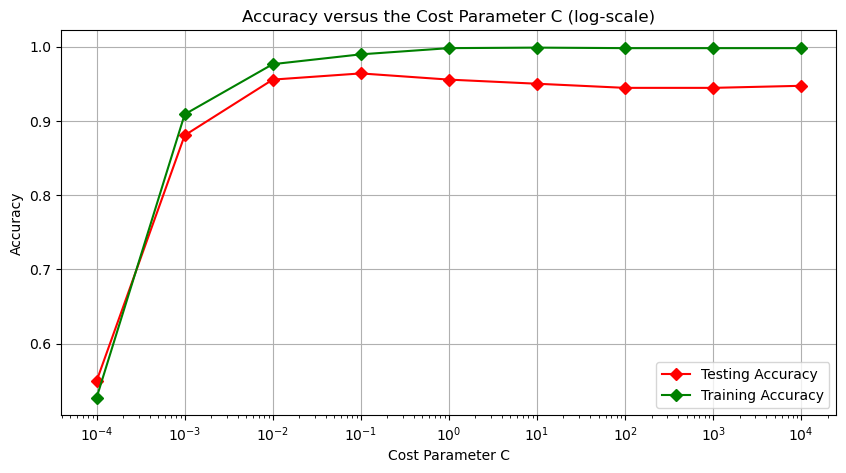

In [15]:
c = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

plt.subplots(figsize=(10, 5))
plt.semilogx(c, acc_l1,'-gD' ,color='red' , label="Testing Accuracy")
plt.semilogx(c, acc_tr_l1,'-gD' , label="Training Accuracy")
plt.grid(True)
plt.xlabel("Cost Parameter C")
plt.ylabel("Accuracy")
plt.legend()
plt.title('Accuracy versus the Cost Parameter C (log-scale)')
plt.show()

We know that "C" is the inverse of regularization strength, so when "C" is too low that means the regularization strength is high. This means the classifier allows more misclassifications in order to generalize, but in the process ends up underfitting, we dont see the effect of decreasing "C" (increasing regularization strength) as much in l2 penalty.

The reason is L1 encourages the ability to create sparse models more than L2. 
Basically since the absolute values or l1 norm is added in the objective function (which is the inverse of the margin as discussed), the classifier wants to minimize these absolute values as much as possible in order to get the maximum margin. this process results in few of the weights (coefficients) being set to 0 gradually and so only some of the features get used in the prediction, therefore resulting in underfitting.

But in the case of L2 the classifier aims at minimizing the square of the weights (coefficients) which isnt as harsh as the L1 penalty and results in a smoothening and thus doesn't encourage sparse models as much (doesnt send some feature weights to 0)

In [16]:
# choosing the parameter that resulted in the highest test accuracy with l1 penalty
high_idx = np.argmax(np.array(acc_l1))
print(f"The highest test accuracy of {round(acc_l1[high_idx]*100,2)} % was achieved with C = {c[high_idx]}")

The highest test accuracy of 96.39 % was achieved with C = 0.1


### SVC using Kernel Trick 

In [17]:
svm_rbf = SVC(C=1.0, kernel='rbf',)
svm_rbf.fit(x_train, y_train)

SVC()

In [18]:
svm_rbf.dual_coef_ .shape

(9, 650)

So now we see that there isn't a coefficient attribute like the linearSVC that is because the SVC using kernel trick only computes the dual coefficients (which denote the coefficient terms in the dual problem which are the lagrangian multipliers learnt during training). 

Since we take a dot product of the input features with the support vectors, each weighted by the corresponding dual coefficient (lagrangian multiplier) the coefficients are only there for the support vectors that are crucial for the decision function in case of a kernel based classifier. 

so the number of coefficients will be the number of support vectors times the (number of class-1) times the number of support vectors. 

In [19]:
svm_rbf.support_vectors_.shape

(650, 64)

The support vectors are basically the initial data points (images) that influence the decision boundary. and we see that in our case that number turns out to be 650. so essentially if we keep this 650 support vectors and decide to remove the other points (images) we will still get the same decision boundary. 

##### Lets look at few of these support vectors

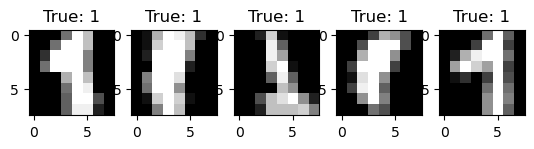

In [20]:
support_indices = svm_rbf.support_
support_vec = svm_rbf.support_vectors_
for i in range(5):
    op = support_vec[50+i].reshape((8,8))
    lbl = y_train[[support_indices][0][50+i]]
    plt.subplot(1, 5, i + 1)
    plt.imshow(op, cmap='gray')
    plt.title(f'True: {lbl}')

plt.show()

In [21]:
pred = svm_rbf.predict(x_test)
accuracy_score(y_test, pred)

0.9861111111111112

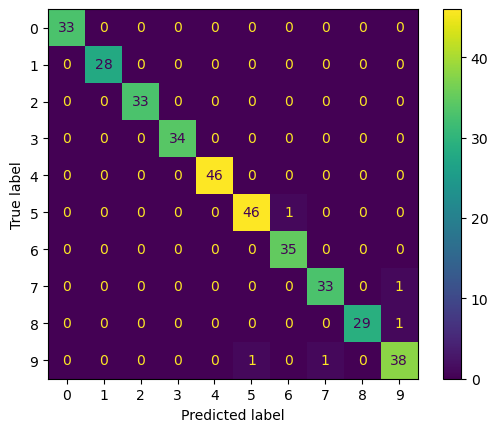

In [22]:
confusion_matrix2 = confusion_matrix(y_test, pred)
ConfusionMatrixDisplay.from_predictions(y_test, pred)
plt.show()

#### Using multiple values of C and gamma

In [27]:
coefficient = []
n_supp = []
sup_vec = []
i = 0
df = pd.DataFrame(columns = ['c','gamma','train_acc','test_acc'])
for c in [0.01, 0.1, 1, 10, 100]:
    for g in [0.01, 0.1, 1, 10, 100, 'scale']:
        svm_rbf = SVC(kernel='rbf', C=c, gamma=g)
        model = svm_rbf.fit(x_train, y_train)
        globals()['model%s' % i] = model
        d_coef = svm_rbf.dual_coef_
        support = svm_rbf.n_support_
        sv = svm_rbf.support_
    
        p_tr = svm_rbf.predict(x_train)
        a_tr = accuracy_score(y_train, p_tr)
    
        pred = svm_rbf.predict(x_test)
        a = accuracy_score(y_test, pred)
    
        coefficient.append(d_coef)
        n_supp.append(support)
        sup_vec.append(sv)
        df.loc[i] = [c,g,a_tr,a]
        i=i+1

In [28]:
df

,c,gamma,train_acc,test_acc
0,0.01,0.01,0.107168,0.077778
1,0.01,0.1,0.107168,0.077778
2,0.01,1.0,0.107168,0.077778
3,0.01,10.0,0.107168,0.077778
4,0.01,100.0,0.107168,0.077778
5,0.01,scale,0.180237,0.130556
6,0.10,0.01,0.107168,0.077778
7,0.10,0.1,0.107168,0.077778
8,0.10,1.0,0.107168,0.077778
9,0.10,10.0,0.107168,0.077778


We see that we get the best results in the default parameter values of the SVC. now lets take a look at this specific model more closely

##### Moving on with C = 1 and gamma = 'scale'

In [30]:
pd.DataFrame(coefficient[17]) # coefficient table of the selected model

,0,1,2,3,4,5,6,7,8,9,...,640,641,642,643,644,645,646,647,648,649
0,0.834414,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.007415,0.280539,...,-0.000000,-0.410435,-0.000000,-0.0,-0.292851,-0.000000,-0.0,-0.000000,-0.000000,-0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,...,-0.000000,-1.000000,-0.378053,-1.0,-1.000000,-1.000000,-0.0,-1.000000,-0.000000,-0.084837
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.050346,0.0,0.00000,0.000000,0.798890,...,-0.000000,-0.000000,-0.000000,-0.0,-0.620109,-0.000000,-0.0,-0.000000,-0.000000,-0.000000
3,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.00000,0.065284,0.623971,...,-0.551984,-0.152775,-1.000000,-0.0,-0.726556,-0.000000,-0.0,-1.000000,-1.000000,-0.000000
4,0.000000,0.000000,0.000000,0.190145,0.000000,1.000000,0.0,0.00000,0.310125,0.852502,...,-0.000000,-0.000000,-0.113126,-0.0,-0.955604,-1.000000,-0.0,-0.274456,-0.000000,-0.000000
5,0.958363,0.000000,0.332857,0.068037,0.002193,0.000000,0.0,0.00000,0.000000,1.000000,...,-0.000000,-0.340562,-1.000000,-0.0,-0.000000,-0.000000,-1.0,-0.000000,-0.095204,-0.000000
6,0.000000,0.000000,0.000000,0.073025,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,...,-0.000000,-0.000000,-0.000000,-0.0,-0.731768,-0.227420,-0.0,-0.000000,-0.000000,-0.000000
7,0.949314,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.209774,...,-0.000000,-0.000000,-0.786470,-0.0,-1.000000,-0.000000,-0.0,-0.000000,-0.000000,-0.000000
8,0.000000,0.154268,0.000000,0.000000,0.000000,0.000000,0.0,0.10579,0.000000,0.515605,...,-0.000000,-1.000000,-0.000000,-1.0,-1.000000,-0.800223,-0.0,-0.000000,-0.685023,-0.085038


In [36]:
# the above table gives us the total support vectors for the entire dataset with num_classes-1 
for i in range(len(n_supp[17])):
    print(f"There are {n_supp[17][i]} support vectors for class {i}")

There are 41 support vectors for class 0
There are 85 support vectors for class 1
There are 62 support vectors for class 2
There are 69 support vectors for class 3
There are 57 support vectors for class 4
There are 61 support vectors for class 5
There are 44 support vectors for class 6
There are 60 support vectors for class 7
There are 95 support vectors for class 8
There are 76 support vectors for class 9


So now for each class 
1. the positive support vectors are the corresponding support vectors of that class 
2. the negative support vectors are all the support vectors of the rest of the classes.

so for Ex. there are 41 positive support vectors for class 0 and 609 negative support vectors for it

##### Looking at positive support vectors for each class

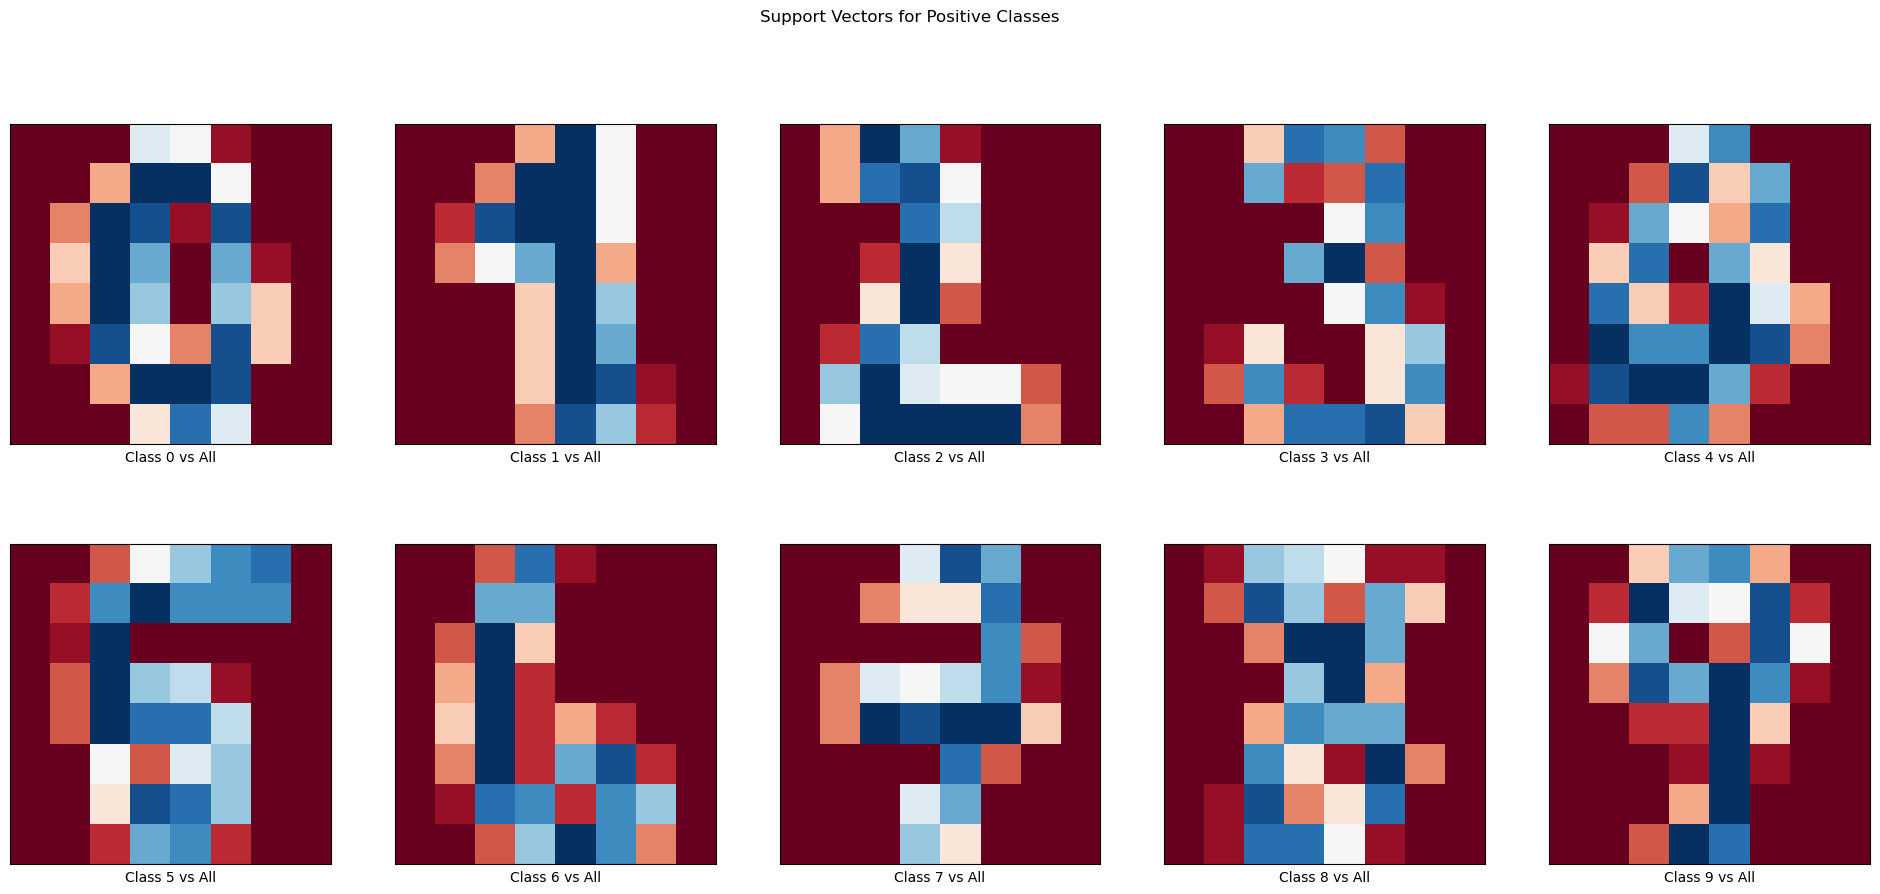

In [38]:
ind = 0
plt.subplots(2,5, figsize=(24,10))
for i in range(len(n_supp[17])):
    l1 = plt.subplot(2, 5, i + 1)
    sv_image = x_train[sup_vec[17][ind:ind+n_supp[17][i]]][0]
    l1.imshow(sv_image.reshape(8, 8), cmap=plt.cm.RdBu)
    l1.set_xticks(())
    l1.set_yticks(())
    l1.set_xlabel('Class %i vs All' % i)
    ind = ind + n_supp[17][i]
plt.suptitle('Support Vectors for Positive Classes')
plt.show()

We see that the positive support vectors resemble the digits correctly, which is what we want

##### Looking at Negative support vectors for each class

we already saw that any support vector that doesn't belong to a certain class is defined as a negative support vector for that class. For each class, we will be taking the support vectors of the next class as its negative support vector

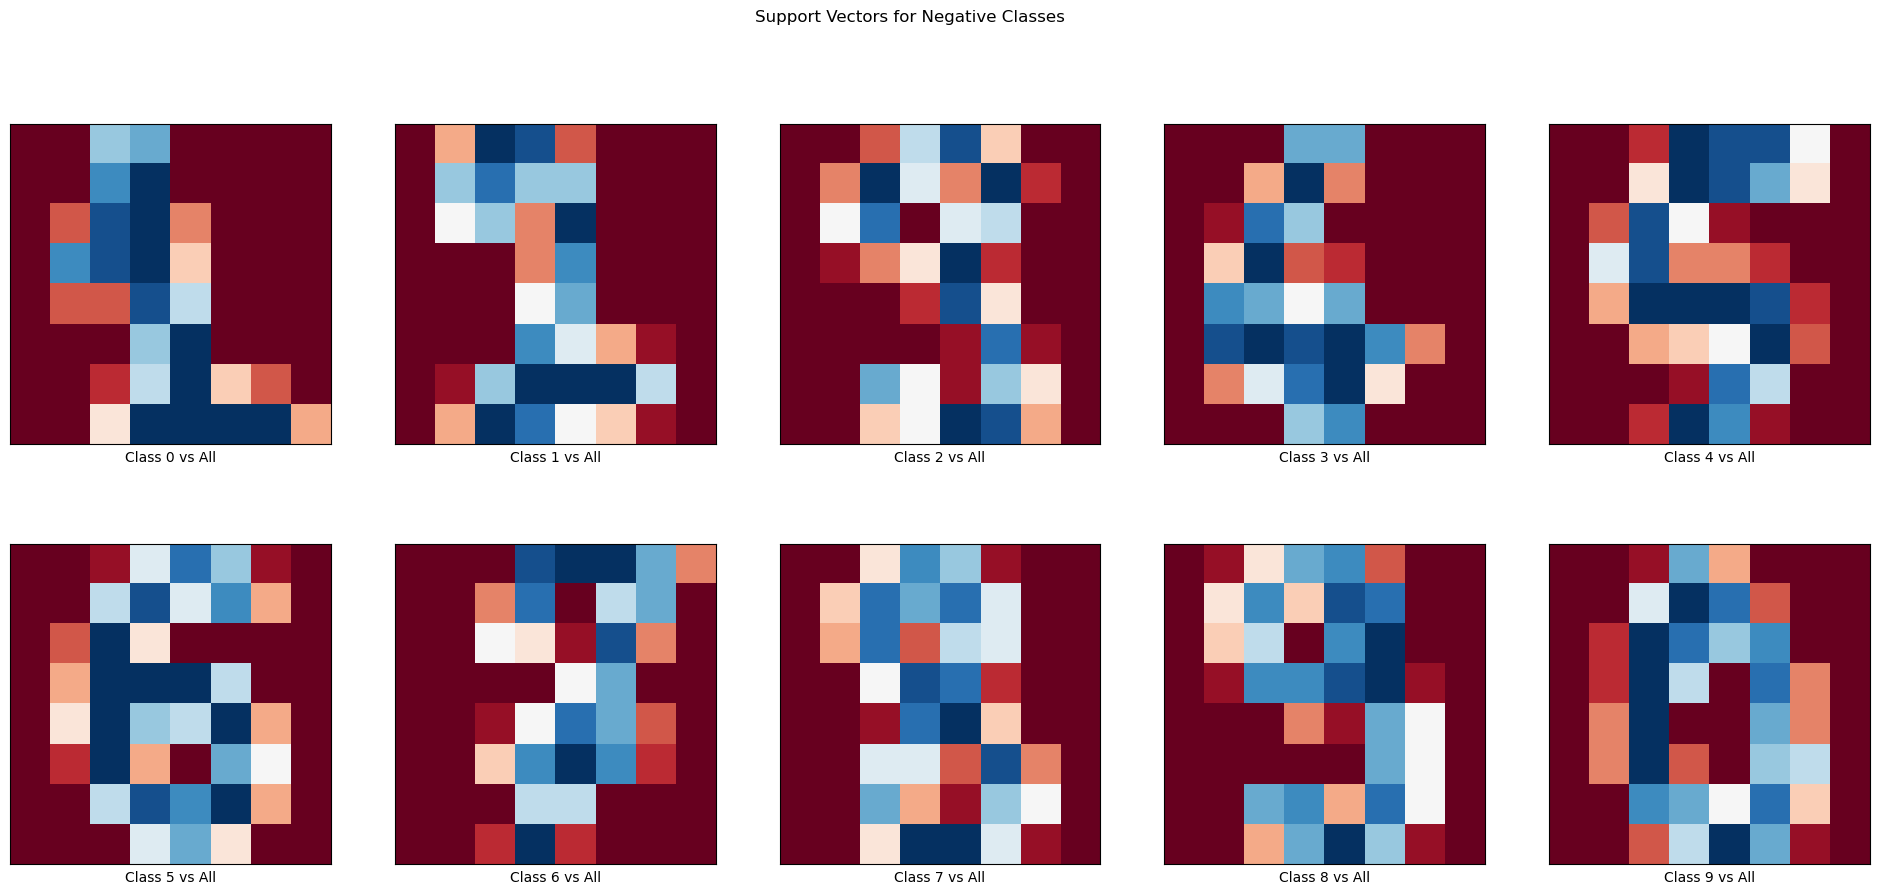

In [48]:
ind = n_supp[17][0]
plt.subplots(2,5, figsize=(24,10))
for i in range(len(n_supp[17])-1):
    l1 = plt.subplot(2, 5, i + 1)
    sv_image = x_train[sup_vec[17][ind:ind+n_supp[17][i+1]]][2]
    l1.imshow(sv_image.reshape(8, 8), cmap=plt.cm.RdBu)
    l1.set_xticks(())
    l1.set_yticks(())
    l1.set_xlabel('Class %i vs All' % i)
    ind = ind + n_supp[17][i+1]
ind = 0
l1 = plt.subplot(2, 5, 10)
sv_image = x_train[sup_vec[17][ind:ind+n_supp[17][0]]][2]
l1.imshow(sv_image.reshape(8, 8), cmap=plt.cm.RdBu)
l1.set_xticks(())
l1.set_yticks(())
l1.set_xlabel('Class 9 vs All')
plt.suptitle('Support Vectors for Negative Classes')
plt.show()

We can clealy see the difference in the true class and negative support vectors.

It can be shown that any of the others classes defining support vectors serve as negative support vectors for every other class

In [ ]:
# (a, b), (c, d) = tf.keras.datasets.mnist.load_data()
# assert a.shape == (60000, 28, 28)
# assert c.shape == (10000, 28, 28)
# assert b.shape == (60000,)
# assert d.shape == (10000,)

In [ ]:
# # we want our data points to be flattened as it will help in our computation
# a = a.reshape((a.shape[0], -1))
# c = c.reshape((c.shape[0], -1))
# assert a.shape == (60000, 784)
# assert c.shape == (10000, 784)

##### To reduce computation time, we are going to take only a small subset of the entire data available in the train and test set

In [ ]:
# np.random.seed(42) #setting the seed to reproduce the results

# # performing a random sampling of images available to us
# num_samples = 8000
# random_indices = np.random.choice(len(a), size=num_samples, replace=False) # Generate random indices

# # Select the corresponding subset from the features and labels
# x_train = a[random_indices]
# y_train = b[random_indices]

# # similarly for the test set
# num_samples = 3000
# random_indices = np.random.choice(len(c), size=num_samples, replace=False)
# x_test = c[random_indices]
# y_test = d[random_indices]

In [ ]:
# print(f"The shape of x_train: {x_train.shape}")
# print(f"The shape of y_train: {y_train.shape}")
# print(f"The shape of x_test: {x_test.shape}")
# print(f"The shape of y_test: {y_test.shape}")

##### Viewing a few images

In [ ]:
# classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
# num_classes = len(classes)
# samples = 4

# plt.subplots(figsize=(12, 4.5))
# for y, cls in enumerate(classes):
#     idxs = np.nonzero([i == y for i in y_train])
#     idxs = np.random.choice(idxs[0], samples, replace=False)
#     for i , idx in enumerate(idxs):
#         plt_idx = i * num_classes + y + 1
#         plt.subplot(samples, num_classes, plt_idx)
#         plt.imshow(x_train[idx].reshape((28, 28)))
#         plt.axis("off")
#         if i == 0:
#             plt.title(cls)
        

# plt.show()

In [ ]:
# temp1 = dict(Counter(y_train))
# for i,k in temp1.items():
#     print(f"There are {k} data points of class {i}")

### Model Building

#### Linear SVC

In [ ]:
# start_time = time()
# svm = LinearSVC(dual=False)
# svm.fit(x_train, y_train)
# end_time = time()

In [ ]:
# print(f"Execution Time: {round(end_time-start_time,2)} seconds")

In [ ]:
# svm.intercept_

In [ ]:
# pred = svm.predict(x_test)

In [ ]:
# accuracy_score(y_test, pred) # Accuracy

In [ ]:
# cm = confusion_matrix(y_test, pred)
# ConfusionMatrixDisplay.from_predictions(y_test, pred)
# plt.show()

In [ ]:
# start_time = time()
# acc = []
# acc_tr = []
# coefficient = []
# for c in [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]:
#     svm = LinearSVC(dual=False, C=c)
#     svm.fit(x_train, y_train)
#     coef = svm.coef_
    
#     p_tr = svm.predict(x_train)
#     a_tr = accuracy_score(y_train, p_tr)
    
#     pred = svm.predict(x_test)
#     a = accuracy_score(y_test, pred)
    
#     coefficient.append(coef)
#     acc_tr.append(a_tr)
#     acc.append(a)

# end_time = time()

In [ ]:
# print(f"Execution time: {round((end_time-start_time)/60,2)} mins")

In [ ]:
# c = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

# plt.subplots(figsize=(10, 5))
# plt.semilogx(c, acc,'-gD' ,color='red' , label="Testing Accuracy")
# plt.semilogx(c, acc_tr,'-gD' , label="Training Accuracy")
# plt.grid(True)
# plt.xlabel("Cost Parameter C")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.title('Accuracy versus the Cost Parameter C (log-scale)')
# plt.show()

In [ ]:
# svm_coef = coefficient[0]
# svm_coef.shape

In [ ]:
# train_path = r"C:\Users\user\Documents\ML\datasets\MNIST\train.csv"
# data = pd.read_csv(train_path)

In [ ]:
# test_path = r"C:\Users\user\Documents\ML\datasets\MNIST\test.csv"
# test_data = pd.read_csv(test_path)

In [ ]:
# data.shape

In [ ]:
# test_data.shape

In [ ]:
# # we will split the labels from the image data and store it in labels and pixel values variables
# labels = data['label'] # 1d array of size 42000
# pixels = data.drop('label', axis=1) # 2d array of 42000 images and each having 784 pixels

In [ ]:
# pixels.shape

In [ ]:
# labels.shape

In [ ]:
# test_data

In [ ]:
# ## lets store the pixel values denoted by many columns as matrix data, so one 2d matrix represents one image
# images = pixels.to_numpy().reshape(-1, 28, 28) # 3d matrix of with 42000 images with each being being of shape 28*28

We are doing this step so that it becomes easier to propogate through the implementation of various feature extraction technique that will be explored later on in this notebook

In [ ]:
# ## lets see an example image
# plt.figure(figsize=(4,4))
# idx = 323

# # images are stored in the "images" variable and each index of "images" denotes one image 
# plt.imshow(images[idx], cmap='gray')
# plt.title('Label: ' + str(labels[idx]))

In [ ]:
# data['label'].value_counts()

<!-- The data is split fairly evenly so we wouldnt need to focus on sampling techniques -->

In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.2, random_state = 42)

In [ ]:
# svm_classifier = SVC(random_state=42)
# param_grid = {
#     'C': [0.1],
#     'kernel': [ 'poly'],
#     'gamma': ['auto']
# }

# grid_search_svm = GridSearchCV(svm_classifier, param_grid, cv=5)
# grid_search_svm.fit(x_train, y_train)

# best_params = grid_search_svm.best_params_
# print(f"Best Hyperparameters: {best_params}")

# # Evaluate on the test set
# model_svm = grid_search_svm.best_estimator_

# # Make predictions
# y_pred_svm = model_svm.predict(x_test)

# # Check accuracy of model
# accuracy_svm = accuracy_score(y_test, y_pred_svm)
# conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
# classification_rep_svm = classification_report(y_test, y_pred_svm)

# print(f"Accuracy: {accuracy_svm}")
# print(f"Confusion Matrix:\n{conf_matrix_svm}")
# print(f"Classification Report:\n{classification_rep_svm}")

In [ ]:
# x_test.shape,y_test.shape

In [ ]:
# errors

In [ ]:
# x_test

In [ ]:
# errors = np.where(y_pred_svm != y_test)[0]

# # Display misclassified images
# misclassified_images = x_test_images[errors]
# misclassified_labels = y_test[errors]
# predicted_labels = y_pred_svm[errors]